In [1]:
from cobra.flux_analysis import gapfill
from cobra.flux_analysis.gapfilling import GapFiller
from cobra.io import read_sbml_model
from cobra.io import write_sbml_model
from cobra import Model, Reaction, Metabolite
import pandas
import sys
import re

In [4]:
seedrDB = pandas.read_csv("/home/jo/uni/gapseq/dat/seed_reactions.tsv", sep="\t")
seedmDB = pandas.read_csv("/home/jo/uni/gapseq/dat/seed_metabolites.tsv", sep="\t")
#seedrDB = pandas.read_csv("/home/jo/uni/gapseq/dat/vmh_reactions.csv", sep=",")

In [62]:
def correct_mass(dic): # how to handle wrong charge????
    if dic == {}:
        return True
    else:
        return False

def only_missing_H(dic):
    if len(dic)==1 and "H" in dic:
        return True
    else:
        return False

def repair_mass_balance(model, delete_unbalanced=True, verbose=False):
    mod = model.copy()
    Cwrong = 0
    Ccorrected = 0
    if "cpd00067_c0" not in mod.metabolites:
        h = Metabolite(id="cpd00067_c0", name="H+", formula="H", charge=1)
        mod.add_metabolites(h)
    
    rea_rm = []
    
    mets = [m for m in mod.metabolites if m.formula==""]
    for m in mets:
        mid =re.sub("_.*$","", m.id)
        hit = seedmDB.loc[seedmDB["id"]==mid]
        m.formula = hit["formula"].values[0]
        m.charge = hit["charge"].values[0]
    print len(mets), "compounds without formula, fixed from total", len(mod.metabolites) 
    
    for r in mod.reactions:
        if r in mod.exchanges or r.id=="bio1":
            continue
        
        mbal = r.check_mass_balance()
        if "charge" in mbal:
            mbal.pop("charge") # ToDo: how to handle charge? (is not always in agreement with H!)
        if not correct_mass(mbal): 
            Cwrong += 1
            if not only_missing_H(mbal):
                for m in r.metabolites: # check if one substance causes miss balance => remove
                    tmp = r.copy()
                    tmp.subtract_metabolites({m:-1})
                    mbal2 = tmp.check_mass_balance()
                    if only_missing_H(mbal2):
                        if verbose:
                            print "removed", m.id,m.name, "from", r.id
                            print mbal, mbal2
                        mbal = mbal2
                        r = tmp
                        break
            if only_missing_H(mbal): # check again if corrections worked
                miss = mbal["H"]
            else:
                if verbose:
                    print "could not be fixed"
                    print "\t",r.id, r.name, r.reaction
                    print "\t",mbal
                if delete_unbalanced:
                    rea_rm.append(r)
                    #mod.remove_reactions(r)
                continue
            if miss != round(miss): # check if integer
                print "error in", r.id, "mass imbalance:", mbal
                if delete_unbalanced:
                    rea_rm.append(r)
                    #mod.remove_reactions(r)
                continue
            h = mod.metabolites.get_by_id("cpd00067_c0")
            if miss < 0:
                r.add_metabolites({h: -miss})
            if miss > 0:
                r.subtract_metabolites({h: miss})
            #print mbal, r.check_mass_balance()
            mbal3 = r.check_mass_balance()
            if "charge" in mbal3:
                mbal3.pop("charge")
            if not correct_mass(mbal3):
                if verbose:
                    print r.id, r.name, r.reaction
                    print "old:",mbal, "\tnew:",mbal3
                if delete_unbalanced:
                    rea_rm.append(r)
                    #mod.remove_reactions(r)
            else:
                if verbose:
                    print r.id, "fixed"
                Ccorrected += 1
    mod.remove_reactions(rea_rm)
    #print ",".join([r.name for r in rea_rm])
    #print [r.check_mass_balance() for r in rea_rm]
    mod.repair()
    print "Unbalanced reactions:", Cwrong, "\tCould be corrected:", Ccorrected, "\tRemoved reactions:", len(model.reactions)-len(mod.reactions)
    return(mod)

In [51]:
#mod = read_sbml_model("/home/jo/uni/gapseq/dat/myb71_vhm.xml")
mod = repair_mass_balance(read_sbml_model("/home/jo/uni/gapseq/dat/myb71.xml"), verbose=False)
#mod = repair_mass_balance(read_sbml_model("/home/jo/uni/celegans_microbiome/dat/modelall/MYb10.sbml"), verbose=False)
#mod = repair_mass_balance(read_sbml_model("/home/jo/uni/celegans_microbiome/dat/modelall/MYb11.sbml"), verbose=False)
#mod = repair_mass_balance(read_sbml_model("/home/jo/uni/celegans_microbiome/dat/modelall/MYb237_new.sbml"), verbose=False)
with open("/home/jo/uni/gapseq/myb71Reactions.lst") as f:
#with open("/home/jo/uni/gapseq/newReactions.lst") as f:
    lines = f.read()
newR = lines.split(" ")

1610 compounds without formula, fixed from total 1610
Unbalanced reactions: 0 	Could be corrected: 0 	Removed reactions: 0


In [49]:
mbal["H"]

13.0

In [66]:
#
# Create reference model with reactions pool
#

#refdb  = seedrDB.loc[seedrDB['abbreviation'].isin(newR)] # vmh
refdb  = seedrDB.loc[seedrDB['id'].isin(newR)]
#refdb  = seedrDB.loc[seedrDB['id'].isin("rxn01084")]
refmod = Model("reaction_database")
Rmod   = [re.sub("_.*$", "", r.id) for r in mod.reactions]
print "Consider", len(refdb.index), "reactions"
Cold = 0
Calready = 0
for i,row in refdb.iterrows():
    #rid = row["abbreviation"] # vmh
    rid = row["id"]
    if row["is_obsolete"] == 1: # do not add old reactions
        Cold += 1
        continue
    #if rid in Rmod: # vmh
    elif rid in Rmod:
        Calready += 1
        continue
    r = Reaction(rid)
    refmod.add_reaction(r)
    #rstr = row["formula"] # vmh
    rstr = row["equation"]
    rstr = row["code"]
    rstr = rstr.replace("[0]", "_c0").replace("[1]", "_e0").replace("[3]", "_p0")
    r.build_reaction_from_string(rstr, verbose=False)
    #r.reaction = rstr
for m in refmod.metabolites:
    mid =re.sub("_.*$","", m.id)
    hit = seedmDB.loc[seedmDB["id"]==mid]
    m.name = hit["name"].values[0]
    m.formula = hit["formula"].values[0]
    m.charge = hit["charge"].values[0]

print Calready, "reactions already in the model"
print Cold, "removed deprecated reactions"
refmod = repair_mass_balance(refmod, delete_unbalanced=True)
print len(refmod.reactions), "remaining reaction in reference database:", 

# equation: Unbalanced reactions: 425 	Could be corrected: 4 	Removed reactions: 421
# code: Unbalanced reactions: 1369 	Could be corrected: 949 	Removed reactions: 420
#
# myb71: Unbalanced reactions: 1728 	Could be corrected: 950 	Removed reactions: 778
# myb71: Unbalanced reactions: 1728 	Could be corrected: 1254 	Removed reactions: 474

Consider 3086 reactions
517 reactions already in the model
203 removed deprecated reactions
0 compounds without formula, fixed from total 2460
Unbalanced reactions: 1728 	Could be corrected: 1254 	Removed reactions: 474
1892 remaining reaction in reference database:


In [67]:
Cerror = 0
test = refmod
for r in test.reactions:
    if r in test.exchanges or r.id=="bio1":
            continue
    mbal = r.check_mass_balance()
    if mbal != {} and not (len(mbal)==1 and "charge" in mbal):
        #break
        Cerror += 1
        r.remove_from_model()
print Cerror

0


In [70]:
def set_medium(model, medium):
    mod = model.copy()
    for ex in mod.exchanges:
        ex.lower_bound=0

    for m in medium: # set medium
        #ex = "EX_"+m+"_LPAREN_e_RPAREN_" # vmh
        ex = "EX_"+m+"_e0"
        #ex = m
        if ex in mod.reactions:
            mod.reactions.get_by_id(ex).lower_bound=-1000
        else:
            print "compound not found in model:", m
    return(mod)

In [29]:
minmed = ["glc", "o2", "h2o", "nh4",
         "ca2", "cl", "k", "mg2", "na1", "pi", "cu2", "fe2", "fe3", "mn2", "zn2"]
modmin = set_medium(mod, minmed)

compound not found in model: fe2


In [71]:
#
# Iterate by biomass components and try to produce components step-wise by minimal medium only
# => if biomass component could not be produced => gapfilling
#

#richmed = ["EX_cpd00001_e0", "EX_cpd00007_e0","EX_cpd00009_e0", "EX_cpd00018_e0", "EX_cpd00023_e0", "EX_cpd00027_e0", "EX_cpd00028_e0", "EX_cpd00030_e0", "EX_cpd00033_e0", "EX_cpd00034_e0", "EX_cpd00035_e0", "EX_cpd00039_e0", "EX_cpd00041_e0", "EX_cpd00046_e0", "EX_cpd00048_e0", "EX_cpd00051_e0", "EX_cpd00054_e0", "EX_cpd00058_e0", "EX_cpd00060_e0", "EX_cpd00063_e0", "EX_cpd00065_e0", "EX_cpd00066_e0", "EX_cpd00067_e0", "EX_cpd00069_e0", "EX_cpd00084_e0", "EX_cpd00091_e0", "EX_cpd00092_e0", "EX_cpd00099_e0", "EX_cpd00107_e0", "EX_cpd00119_e0", "EX_cpd00126_e0", "EX_cpd00129_e0", "EX_cpd00149_e0", "EX_cpd00156_e0", "EX_cpd00161_e0", "EX_cpd00182_e0", "EX_cpd00184_e0", "EX_cpd00205_e0", "EX_cpd00215_e0", "EX_cpd00218_e0", "EX_cpd00219_e0", "EX_cpd00220_e0", "EX_cpd00226_e0", "EX_cpd00239_e0", "EX_cpd00246_e0", "EX_cpd00249_e0", "EX_cpd00254_e0", "EX_cpd00311_e0", "EX_cpd00322_e0", "EX_cpd00381_e0", "EX_cpd00383_e0", "EX_cpd00393_e0", "EX_cpd00438_e0", "EX_cpd00531_e0", "EX_cpd00541_e0", "EX_cpd00644_e0", "EX_cpd00654_e0", "EX_cpd00793_e0", "EX_cpd00971_e0", "EX_cpd01012_e0", "EX_cpd01048_e0", "EX_cpd03424_e0", "EX_cpd10515_e0", "EX_cpd10516_e0", "EX_cpd11595_e0"]
minmed = ["cpd00027", "cpd00007", "cpd00001", # glc, o2, h2o
          #"cpd00020", # pyruvate
          #"cpd00106", # fumarat
          "cpd00013", # nh3
          # minerals
          "cpd00009", "cpd00030", "cpd00034", "cpd00058", "cpd00063", "cpd00067", "cpd00099", "cpd00205", "cpd00254", "cpd10515", "cpd00971", "cpd01012", "cpd10516", "cpd11574"]

#minmed = ["glc", "o2", "h2o", "nh4",
#         "ca2", "cl", "k", "mg2", "na1", "pi", "cu2", "fe2", "fe3", "mn2", "zn2"]


modmin = set_medium(mod, minmed)
modnew = mod.copy()

ignore = ["H", "Li", "Na", "Mg", "K", "Ca", "P", "Fe", "Cl", "Zn", "Mn", "Mo", "Se", "Co", "Cu", "Ni", "W",
          "H2O"]
    
Call=0; Cwork=0; Cfix=0
fixLater = []
fail = []
relMet = ["cpd00288_c0"]
allMet = mod.reactions.bio1.reactants + [modmin.metabolites.get_by_id(m) for m in relMet]
#allMet = mod.reactions.Biomass.reactants # vmh
#bioaa = [m for m in mod.metabolites if m.name.startswith("L_") and m in mod.reactions.bio1.metabolites]
#for m in bioaa:
for m in allMet:
    if m.formula in ignore: # ignore minerals, etc
        continue
    Call += 1
    modtmp = modmin.copy()
    modtmp.objective = modtmp.add_boundary(m, type='demand')
    obj = modtmp.slim_optimize()
    if obj > 0:
        #print "\t => could be produced:"
        Cwork += 1
    else:
        # gapfilling
        print obj, m.id, m.name
        try:
            gapsol = gapfill(modtmp, refmod) # integer_threshold=1e-06
        except RuntimeError:
            print "\t => Runtime error: lowering the integer_threshold?"
            fixLater.append(m)
            continue
        except:
            print "\t => failed:", sys.exc_info()[0]
            fail.append(m)
            continue
        if len(gapsol[0]) > 0:
            Cfix += 1
            print "\t => could be fixed:", ",".join([r.id for r in gapsol[0]])
            modnew.add_reactions([r for r in gapsol[0] if r not in modnew.reactions])
print "\nTotal compounds:", Call, "\t can be produced:", Cwork, "\t could be fixed", Cfix, "\t altogether:", round(100*float(Cwork+Cfix)/Call,1), "%", " (before:",round(100*float(Cwork)/Call,1),"% )"

compound not found in model: cpd10515
compound not found in model: cpd11574
0.0 cpd00241_c0 dGTP_c0
	 => could be fixed: rxn02938
0.0 cpd00015_c0 FAD_c0
	 => could be fixed: rxn02938,rxn05039
0.0 cpd00201_c0 10_Formyltetrahydrofolate_c0
	 => could be fixed: rxn02938
0.0 cpd15695_c0 Diisoheptadecanoylphosphatidylethanolamine_c0
	 => could be fixed: rxn00290
0.0 cpd00107_c0 L_Leucine_c0
	 => could be fixed: rxn02186
0.0 cpd15794_c0 Isoheptadecanoylcardiolipin_B_subtilis_c0
	 => could be fixed: rxn00290
0.0 cpd15665_c0 Peptidoglycan_polymer_n_subunits_c0
	 => failed: <class 'cobra.exceptions.Infeasible'>
0.0 cpd00322_c0 L_Isoleucine_c0
	 => could be fixed: rxn33937
0.0 cpd15793_c0 Stearoylcardiolipin_B_subtilis_c0
	 => could be fixed: rxn10029
0.0 cpd00060_c0 L_Methionine_c0
	 => failed: <class 'cobra.exceptions.Infeasible'>
0.0 cpd00084_c0 L_Cysteine_c0
	 => failed: <class 'cobra.exceptions.Infeasible'>
0.0 cpd00115_c0 dATP_c0
	 => could be fixed: rxn02938
0.0 cpd00264_c0 Spermidine_c0
	

In [ ]:
#myb237
#Total compounds: 66 	 can be produced: 25 	 could be fixed 14 	 altogether: 59.1 %  (before: 37.9 % )


#myb11
# Total compounds: 77 	 can be produced: 35 	 could be fixed 19 	 altogether: 70.1 %  (before: 45.5 % )

# myb10
#Total compounds: 77 	 can be produced: 28 	 could be fixed 23 	 altogether: 66.2 %  (before: 36.4 % )

# myb71
# Total compounds: 77 	 can be produced: 36 	 could be fixed 14 	 altogether: 64.9 %  (before: 46.8 % )
# Total compounds: 77 	 can be produced: 36 	 could be fixed 11 	 altogether: 61.0 %  (before: 46.8 % )

# Total compounds: 76 	 can be produced: 36 	 could be fixed 29 	 altogether: 85.5 %  (before: 47.4 % )
# Total compounds: 76 	 can be produced: 36 	 could be fixed 18 	 altogether: 71.1 %  (before: 47.4 % )

In [43]:
for m in fixLater:
    modtmp = modmin.copy()
    modtmp.objective = modtmp.add_boundary(m, type='demand')
    try:
        #gapsol = gapfill(modtmp, refmod) # integer_threshold=1e-06
        gapsol  = GapFiller(modtmp, refmod, integer_threshold=1e-16).fill()
    except RuntimeError:
            print m.id, m.name, "... no solution found ... still integer_threshold?"

Still integer_threshold?
Still integer_threshold?
Still integer_threshold?
Still integer_threshold?
Still integer_threshold?


In [26]:
#modnew = read_sbml_model("/home/jo/uni/gapseq/myb71_gapfilled.xml")
modnew.summary()
#write_sbml_model(modnew, filename="/home/jo/uni/gapseq/myb71_gapfilled.xml")
write_sbml_model(modnew, filename="/home/jo/uni/gapseq/myb11_gapfilled.xml")

IN FLUXES             OUT FLUXES            OBJECTIVES
--------------------  --------------------  ------------
cpd00024_e0    1e+03  cpd00001_e0    1e+03  bio1  194
cpd00080_e0    1e+03  cpd00011_e0    1e+03
cpd00209_e0  935      cpd00075_e0  927
cpd00122_e0  404      cpd00009_e0  844
cpd00106_e0  393      cpd00036_e0  740
cpd00033_e0  360      cpd00130_e0  710
cpd00307_e0  228      cpd00159_e0  416
cpd00082_e0  198      cpd00276_e0  342
cpd17041_c0  194      cpd11416_c0  194
cpd17042_c0  194      cpd00092_e0  188
cpd17043_c0  194      cpd00117_e0   90.1
cpd00107_e0   89.3    cpd00129_e0   86.6
cpd00156_e0   69.5    cpd00027_e0   47.2
cpd00322_e0   63.4
cpd00054_e0   61.8
cpd00039_e0   60.2
cpd00007_e0   55.3
cpd00073_e0   47.8
cpd00162_e0   40.9
cpd11581_e0   38.9
cpd00309_e0   30.5
cpd00066_e0   29.9
cpd00226_e0   28.1
cpd11590_e0   25.4
cpd00069_e0   23.4
cpd01080_e0   16.5
cpd11584_e0   15.4
cpd00065_e0    9.15
cpd00268_e0    8.28
cpd00393_e0    1.8
cpd00797_e0    1.74
cpd00355_e0

In [84]:
modtmp = set_medium(modnew, minmed) # modnew?
m = modtmp.metabolites.get_by_id("cpd00003_c0")
modtmp.objective = modtmp.add_boundary(m, type='demand')
print modtmp.slim_optimize(), m.id, m.name
print gapfill(modtmp, refmod)

compound not found in model: cpd10515
compound not found in model: cpd11574
0.0 cpd00003_c0 NAD_c0
[[<Reaction rxn31646 at 0x7fd21839cbd0>]]


In [93]:
rea = refmod.reactions.rxn31646
print rea.check_mass_balance()
for m in rea.metabolites:
    print m.id, m.name, m.formula

{'P': -2.0, 'C': -10.0, 'charge': 15.0, 'O': -10.0, 'N': -5.0}
cpd00071_c0 Acetaldehyde C2H4O
cpd00020_c0 Pyruvate C3H3O3
cpd00011_c0 CO2 CO2
cpd00067_c0 H+ H
cpd00008_c0 ADP C10H13N5O10P2


In [78]:
m = mod.metabolites.get_by_id("cpd00309_c0")
for r in m.reactions:
    if r.id=="bio1": continue
    print r.id,":", r.build_reaction_string(use_metabolite_names=False)
    print r.build_reaction_string(use_metabolite_names=True) + "\n"

rxn01225_c0 : cpd00001_c0 + cpd00067_c0 + cpd00207_c0 --> cpd00013_c0 + cpd00309_c0
H2O_c0 + H_plus__c0 + Guanine_c0 --> NH3_c0 + XAN_c0

rxn01297_c0 : cpd00001_c0 + cpd00003_c0 + cpd00226_c0 <=> cpd00004_c0 + cpd00067_c0 + cpd00309_c0
H2O_c0 + NAD_c0 + HYXN_c0 <=> NADH_c0 + H_plus__c0 + XAN_c0

rxn01522_c0 : cpd00001_c0 + cpd00003_c0 + cpd00309_c0 --> cpd00004_c0 + cpd00067_c0 + cpd00300_c0
H2O_c0 + NAD_c0 + XAN_c0 --> NADH_c0 + H_plus__c0 + Urate_c0

rxn01544_c0 : cpd00103_c0 + cpd00309_c0 --> cpd00012_c0 + cpd00067_c0 + cpd00497_c0
PRPP_c0 + XAN_c0 --> PPi_c0 + H_plus__c0 + XMP_c0

rxn01545_c0 : cpd00001_c0 + cpd01217_c0 <=> cpd00105_c0 + cpd00309_c0
H2O_c0 + Xanthosine_c0 <=> D_Ribose_c0 + XAN_c0



In [40]:
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
from cobra.flux_analysis import pfba
import pandas

In [59]:
med = ["cpd11606", "cpd00305","cpd00048","cpd00058", "cpd00034", "cpd10516", "cpd00254", "cpd00205", "cpd00030", "cpd00149", "cpd00099", "cpd00063"]
minmed = ["cpd00027", "cpd00007", "cpd00001", # glc, o2, h2o
          "cpd00013", # nh3
          # minerals
          "cpd00009", "cpd00030", "cpd00034", "cpd00058", "cpd00063", "cpd00067", "cpd00099", "cpd00205", "cpd00254", "cpd10515", "cpd00971", "cpd01012", "cpd10516", "cpd11574"]

modtmp = set_medium(modnew, minmed)
nominal = modtmp.optimize()
loopless = loopless_solution(modnew)
print nominal.objective_value, loopless.fluxes["bio1"]

compound not found in model: cpd10515
compound not found in model: cpd11574
-1.56153224243e-13 271.282955535


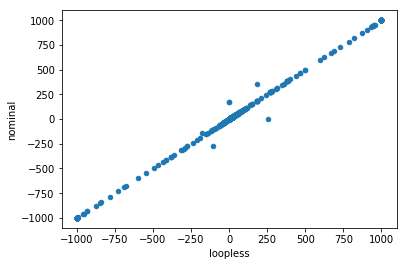

In [48]:
df = pandas.DataFrame(dict(loopless=loopless.fluxes, nominal=nominal.fluxes))
df.plot.scatter(x='loopless', y='nominal')